# Prerequisites

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from models import *

Populating the interactive namespace from numpy and matplotlib


/home/mdindin/Project_Dyskinesia/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# [Data Set](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions) Description

The experiments were carried out with a group of 30 volunteers within an age bracket of 19-48 years. 
They performed a protocol of activities composed of six basic activities: three static postures (standing, sitting, lying) and three dynamic activities (walking, walking downstairs and walking upstairs). 
The experiment also included postural transitions that occurred between the static postures. These are: stand-to-sit, sit-to-stand, sit-to-lie, lie-to-sit, stand-to-lie, and lie-to-stand.

All the participants were wearing a smartphone (Samsung Galaxy S II) on the waist during the experiment execution. 
We captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz using the embedded accelerometer and gyroscope of the device. 
The experiments were video-recorded to label the data manually. The obtained dataset was randomly partitioned into two sets, where 70 percents of the volunteers was selected for generating the training data and 30 percents the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). 
The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. 
The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.
From each window, a vector of 561 features was obtained by calculating variables from the time and frequency domain.

In [3]:
with open('activity_labels.txt', 'r') as raw : res = raw.readlines()
activities = []
for ele in res : activities.append(ele.split(' ')[1])

### First observation on Method

Since I use both the features and the raw signals, I tried to link both thanks to the explanations given in the introduction. Since the explanations are kinda clear, a simple check-out is enough to verify whether the features were extracted this way, to make sure both the raw signals and the features match together. We are then good to go ! Secondly, I made sure the labels obtained thanks to the splitting of signals and the reading of the features did match, which did also work.

In [4]:
fea = Loader().load_fea()
des = Loader().load_signals().description

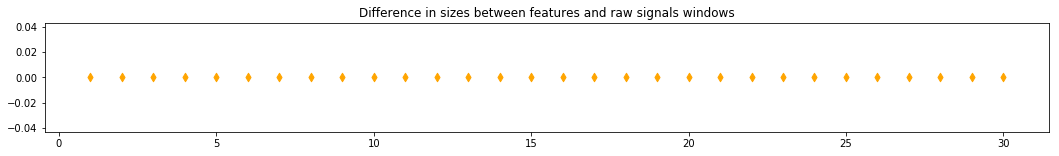

In [5]:
dif = []
for ids in sorted(list(fea.usr_train) + list(fea.usr_valid)) :
    if ids in fea.usr_train : cnt, fts = 0, len(np.where(fea.train['Subjects'] == ids)[0])
    elif ids in fea.usr_valid : cnt, fts = 0, len(np.where(fea.valid['Subjects'] == ids)[0])
    for val in des.query('User == {}'.format(ids)).values :
        cnt += windows(val[-1] - val[-2] + 1, fea.time_window, fea.overlap_rto)
    dif.append(cnt - fts)

plt.figure(figsize=(18,2))
plt.scatter(range(1,31), dif, marker='d', c='orange')
plt.title('Difference in sizes between features and raw signals windows')
plt.show()

We will also notice that some of the features labels are redundant, and will provok disturbances into the models. Among them, there is :

In [6]:
with open('./Fea_Data/features.txt') as raw : lab = raw.readlines()
for ind in range(len(lab)) : lab[ind] = lab[ind].replace('\n','').replace(' ','')
ele = remove_doublon([lbl for lbl in lab if len(np.where(np.asarray(lab) == lbl)[0]) > 1])
print(', '.join(ele))

tBodyAcc-ropy-1, tGravityAcc-ropy-1, tBodyAccJerk-ropy-1, tBodyGyro-ropy-1, tBodyGyroJerk-ropy-1, fBodyAcc-ropy-1, fBodyAcc-Skewness-1, fBodyAcc-Kurtosis-1, fBodyAccJerk-ropy-1, fBodyAccJerk-Skewness-1, fBodyAccJerk-Kurtosis-1, fBodyGyro-ropy-1, fBodyGyro-Skewness-1, fBodyGyro-Kurtosis-1


# Model based on Features only

In [7]:
m_0 = Models('RandomForest').load_model()

  ! Fea_Train_Mean : 0.0, Fea_Valid_Mean : -0.001
  ! Hdf_Train_Mean : 0.0, Hdf_Valid_Mean : 0.041


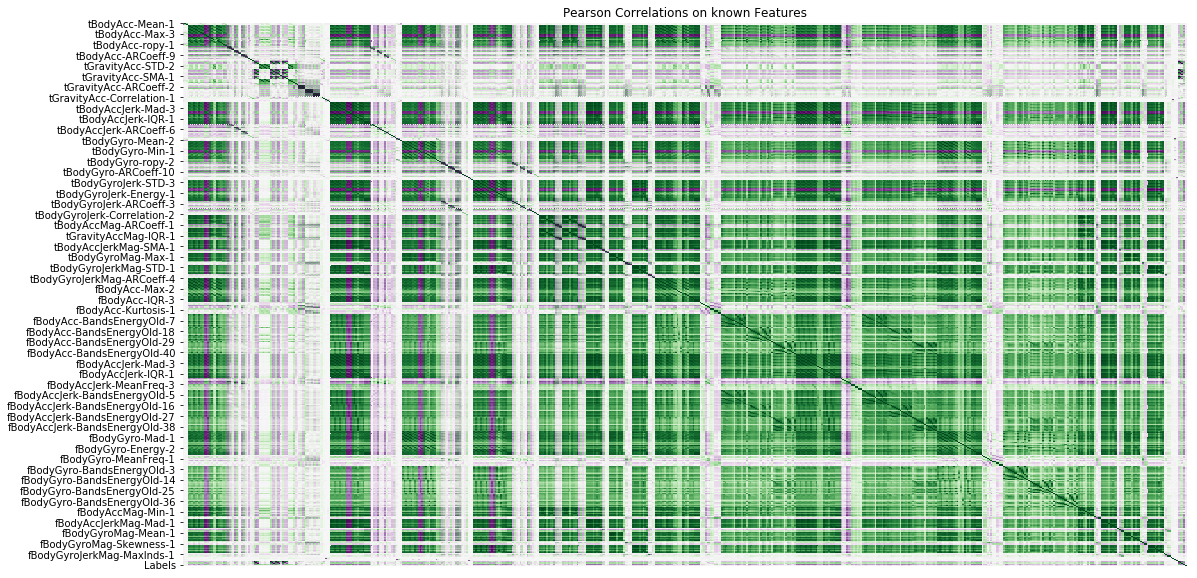

In [10]:
plt.figure(figsize=(18,10))
sb.heatmap(fea.train.corr(), cmap='PRGn', cbar=False, xticklabels=False)
_ = plt.title('Pearson Correlations on known Features')

As seen above, there are plenty of features strongly correlated together. The information brought thanks to those is clearly redundant, and selection has to be applied, as to enhance the rapidity of the training but also reduce a possible overfitting. Generalisation is still and ever the main aim of such exercice.

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

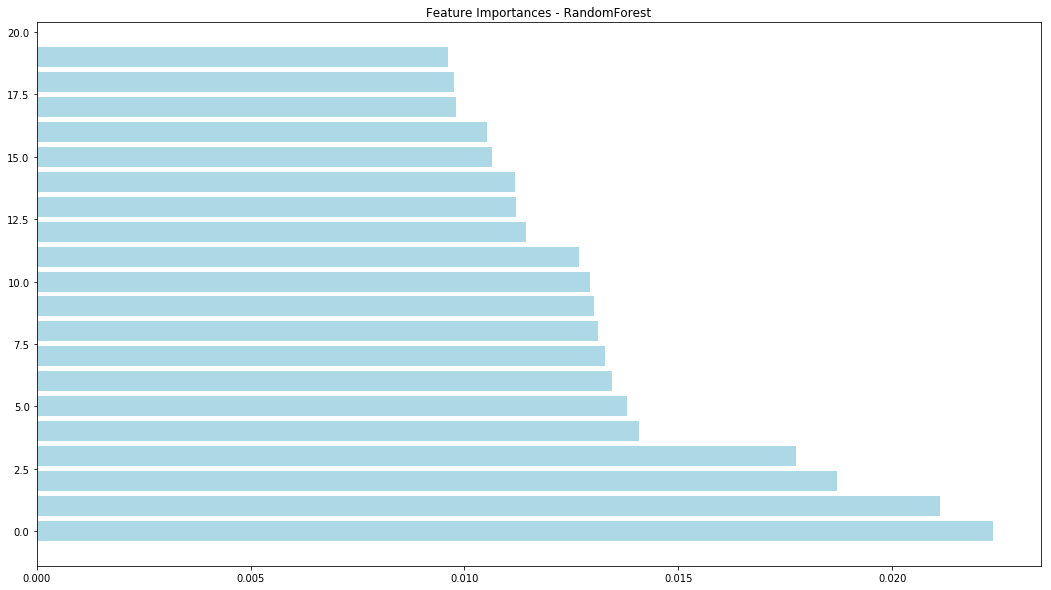

In [11]:
m_0.plot_importances()

In [12]:
m_0.performance()

ValueError: Number of features of the model must match the input. Model n_features is 561 and input n_features is 1072 

In [13]:
m_1 = Models('XGBoost').load_model()

  ! Fea_Train_Mean : 0.0, Fea_Valid_Mean : -0.001
  ! Hdf_Train_Mean : 0.0, Hdf_Valid_Mean : 0.041


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

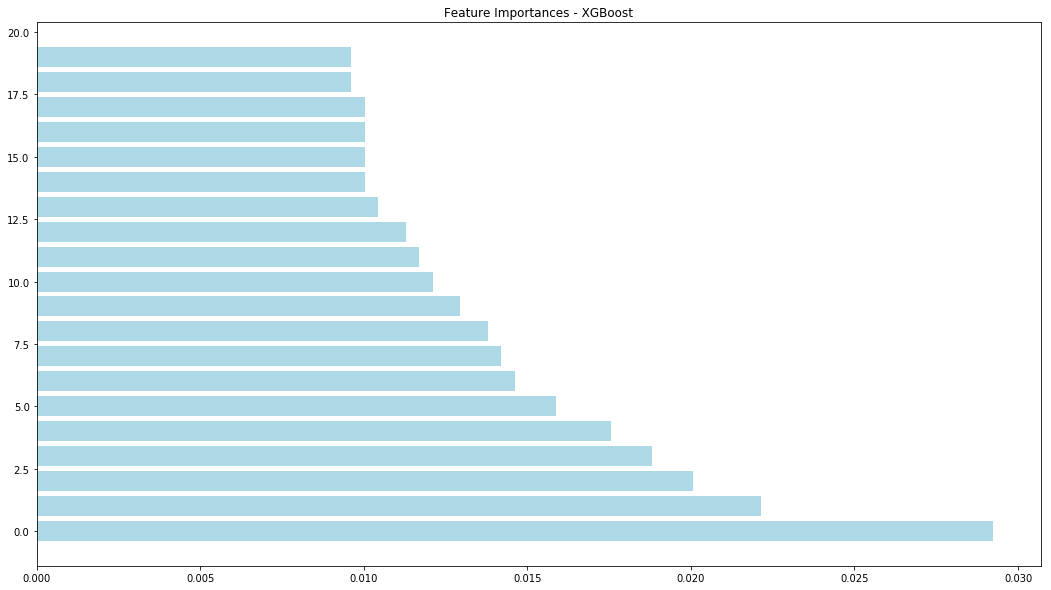

In [14]:
m_1.plot_importances()

In [15]:
m_1.performance()

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071']
training data did not have the following fields: f600, f601, f602, f603, f604, f605, f606, f607, f608, f609, f791, f769, f768, f767, f766, f765, f764, f763, f762, f761, f760, f798, f1028, f1029, f1026, f1027, f1024, f799, f1022, f1023, f1020, f1021, f932, f933, f930, f931, f936, f937, f934, f935, f938, f939, f699, f698, f693, f692, f691, f690, f697, f696, f695, f694, f590, f591, f592, f593, f594, f595, f989, f597, f598, f599, f985, f984, f983, f982, f981, f980, f730, f731, f732, f733, f734, f735, f736, f737, f631, f630, f637, f636, f891, f722, f721, f720, f727, f726, f725, f724, f899, f898, f729, f728, f1062, f1063, f1060, f1061, f1066, f1067, f1064, f1065, f1068, f1069, f701, f808, f876, f806, f807, f804, f805, f802, f803, f800, f801, f702, f873, f704, f796, f797, f794, f795, f792, f793, f659, f658, f657, f656, f655, f654, f653, f652, f651, f650, f1025, f572, f573, f570, f571, f576, f577, f574, f575, f578, f579, f976, f977, f974, f975, f972, f973, f970, f971, f978, f979, f723, f875, f613, f612, f611, f610, f617, f616, f615, f614, f619, f618, f758, f759, f752, f753, f750, f751, f756, f757, f754, f755, f855, f854, f857, f856, f851, f850, f853, f852, f1013, f1012, f1011, f1010, f859, f858, f1015, f1014, f929, f928, f925, f924, f927, f926, f921, f920, f923, f922, f583, f582, f581, f580, f587, f586, f585, f584, f589, f588, f596, f988, f987, f986, f743, f629, f868, f869, f718, f719, f864, f717, f866, f715, f712, f713, f710, f711, f1059, f1058, f1057, f1056, f1055, f1054, f1053, f1052, f1051, f1050, f819, f818, f811, f810, f813, f812, f815, f814, f817, f816, f781, f780, f783, f669, f785, f784, f787, f786, f662, f663, f660, f661, f666, f667, f664, f665, f716, f865, f639, f714, f914, f915, f916, f867, f910, f911, f912, f913, f860, f918, f919, f861, f569, f568, f565, f564, f567, f566, f561, f563, f562, f961, f960, f963, f962, f965, f964, f967, f966, f969, f968, f745, f744, f747, f746, f741, f740, f628, f742, f626, f627, f624, f625, f749, f748, f620, f621, f1004, f1005, f1006, f1007, f1000, f1001, f1002, f1003, f1008, f1009, f820, f821, f822, f823, f824, f825, f826, f827, f828, f829, f958, f959, f950, f951, f952, f953, f954, f955, f956, f957, f683, f862, f863, f790, f668, f782, f709, f708, f879, f878, f877, f700, f703, f874, f705, f872, f871, f870, f789, f788, f1048, f1049, f1040, f1041, f1042, f1043, f1044, f1045, f1046, f1047, f675, f674, f677, f676, f671, f670, f673, f672, f679, f678, f778, f779, f774, f775, f776, f777, f770, f771, f772, f773, f890, f1039, f1038, f1035, f1034, f1037, f1036, f1031, f1030, f1033, f1032, f907, f906, f905, f904, f903, f902, f901, f900, f893, f909, f908, f892, f895, f894, f688, f689, f897, f680, f681, f682, f896, f684, f685, f686, f687, f998, f999, f994, f995, f996, f997, f990, f991, f992, f993, f638, f917, f707, f1019, f1018, f706, f886, f887, f884, f885, f882, f883, f880, f881, f738, f739, f633, f632, f635, f634, f888, f889, f1071, f1070, f1017, f1016, f833, f832, f831, f830, f837, f836, f835, f834, f839, f838, f949, f948, f943, f942, f941, f940, f947, f946, f945, f944, f648, f649, f644, f645, f646, f647, f640, f641, f642, f643, f809, f622, f623, f848, f849, f842, f843, f840, f841, f846, f847, f844, f845

# Model based on Raw Signals only

In [16]:
m_2 = Models('Conv1D').load_model()

  ! Raw_Train_Mean : -0.0, Raw_Valid_Mean : -0.0


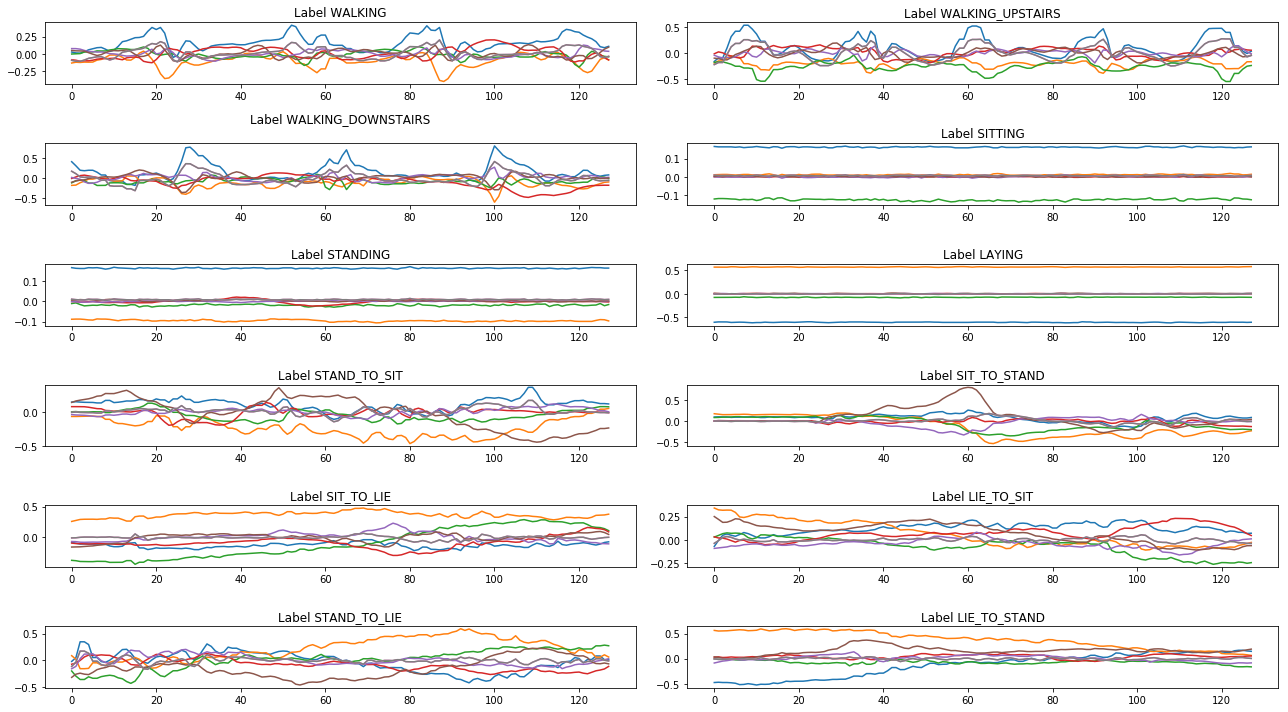

In [20]:
plt.figure(figsize=(18,10))
n_l = len(np.unique(m_2.l_t))
for ind, lab in enumerate(np.unique(m_2.l_t)) :
    plt.subplot((n_l + n_l%2)/2, 2, ind+1)
    plt.title('Label {}'.format(activities[lab]))
    plt.plot(m_2.r_t[np.random.choice(np.where(m_2.l_t == lab)[0])].transpose())
plt.tight_layout()
plt.show()

The model is build on another machine. Loading it to check out its performances is still necessary, and way faster.

In [21]:
m_2.performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
Acc,0.946237,0.998429,0.997134,0.999818,0.927484,0.937937,0.999809,0.934145,1.0,0.904333,0.779203,0.795115,0.831260
Rec,0.946237,0.997984,0.995754,1.000000,0.877953,0.899281,1.000000,0.869565,1.0,0.812500,0.560000,0.591837,0.666667
Pre,0.946366,0.998874,0.998509,0.999635,0.974489,0.974631,0.999618,0.998537,1.0,0.995304,0.997162,0.997293,0.993818
F1S,0.945752,0.998429,0.997130,0.999818,0.923705,0.935441,0.999809,0.929599,1.0,0.894659,0.717216,0.742840,0.798015


In [22]:
m_3 = Models('Conv2D').load_model()

  ! Raw_Train_Mean : -0.0, Raw_Valid_Mean : -0.0


In [23]:
m_3.performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
Acc,0.897533,0.962702,0.983280,0.990421,0.884538,0.869938,0.999618,0.912088,0.949841,0.810583,0.858725,0.793830,0.813698
Rec,0.897533,0.925403,0.970276,0.997619,0.816929,0.775180,1.000000,0.826087,0.900000,0.625000,0.720000,0.591837,0.629630
Pre,0.898887,1.000000,0.996185,0.983462,0.944665,0.956442,0.999236,0.997691,0.999648,0.993903,0.996471,0.992993,0.996466
F1S,0.897299,0.961257,0.983060,0.990490,0.876166,0.856324,0.999618,0.903816,0.947210,0.767420,0.835970,0.741644,0.771670


# Model based on Raw Signals and Features

In [24]:
m_3 = Models('DeepConv1D').load_model()

  ! Fea_Train_Mean : 0.0, Fea_Valid_Mean : -0.001
  ! Hdf_Train_Mean : 0.0, Hdf_Valid_Mean : 0.041
  ! Raw_Train_Mean : -0.0, Raw_Valid_Mean : -0.0


In [25]:
m_3.performance()

ValueError: Error when checking model : the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 9 array(s), but instead got the following list of 10 arrays: [array([[[ 0.17637736],
        [ 0.17637736],
        [ 0.20317264],
        ..., 
        [ 0.13779215],
        [ 0.14100762],
        [ 0.14100762]],

       [[ 0.13672037],
        [ 0.15172574],...

In [26]:
m_4 = Models('DeepConv2D').load_model()

  ! Fea_Train_Mean : 0.0, Fea_Valid_Mean : -0.001
  ! Hdf_Train_Mean : 0.0, Hdf_Valid_Mean : 0.041
  ! Raw_Train_Mean : -0.0, Raw_Valid_Mean : -0.0


In [ ]:
m_4.performance()